<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/Overnight_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip3 install pyfolio
import pyfolio as pyf

** OVERNIGHT TRADING STRATEGY**

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [32]:
!pip install datetime
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# For data manupulations

START = '2021-08-03'
END = '2023-08-04'

VOLATILITY_FACTOR = 0.45
R_WINDOW = 32
REVERSED = True
LEFT, RIGHT = datetime.date(2021, 8, 3), datetime.date(2023, 8, 4)

# VF    LB    PEAK_CUM  CUM_LAST    REVERSED
# 0.25  45    6.11       4.29 OK    True
# 0.35  45    7.42       5.02 OK    True
# 0.40  45    7.64       5.17 OK    True
# 0.45  45    8.99       6.16 OK    True
# 0.45  45    1.22       1.05 OK    False
# 0.45  55    7.97       5.39 OK    True
# 0.45  40    9.35       6.31 OK    True
# 0.45  35    9.65       7.14 OK    True
# 0.45  33    9.78       7.24 OK    True  ***
# 0.45  32    10.02      7.42 OK    True  ****
# 0.45  30    9.16       6.78 OK    True
# 0.45  25    8.19       5.98 OK    True
# -   -       5.17       4.82 OK    True / original Gap up buy side.

Ticker = "EREGL"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
#      Feasibility
# EREGL 2.26
# ASELS 1.53
# THYAO 0.34
# GARAN 0.78
# KCHOL 0.598
# ISDMR 1.5
# QUAGR 0.90
# CANTE 0.15
# EUPWR 0.59
# YKBNK 0.78
# DOAS  0.81
# INFO  0.34
# TUPRS 0.73

# Read data from Yahoo finance
TickerIS = Ticker + ".IS"
data = yf.download(TickerIS,START, END)

data_close = data['Adj Close']

data_rel = data['Adj Close'] / data['Adj Close'][0]

# Convert index into datetime format
data.index = pd.to_datetime(data.index,format="%d-%m-%Y")

# Calculate adjustment factor
adjusted_factor = data['Adj Close'] / data['Close']

# Calculate adjusted open price
data['Adj Open'] = adjusted_factor * data['Open']

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Adj Open
Date,,,,,,,
2023-07-28,38.200001,38.720001,38.180000,38.459999,38.459999,133192659,38.200001
2023-07-31,38.759998,42.000000,38.759998,41.700001,41.700001,314351426,38.759998
2023-08-01,41.560001,42.200001,40.680000,40.759998,40.759998,197475026,41.560001
2023-08-02,40.759998,42.320000,40.580002,40.939999,40.939999,166375142,40.759998
2023-08-03,41.040001,41.700001,40.240002,40.400002,40.400002,115783387,41.040001


In [33]:
# Calculate returns
data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)

In [34]:
# Calculate standard deviation of returns
data['std'] = data['returns'].rolling(R_WINDOW).std()

In [35]:
data['positions'] = np.nan

In [36]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [37]:
# IMPROVED STRATEGY

# Long entry condition
if REVERSED:
  long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
else:
# Short entry condition
  long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']


In [38]:
# Store 1 when long entry condition is true
data.loc[long_entry, 'positions'] = 1

# Store -1 when short entry condition is true
#data.loc[short_entry, 'positions'] = -1

# Store 0 when wait condition is true
data.loc[short_entry, 'positions'] = 0

data['positions'].fillna(method='ffill', inplace=True)

# Drop NaN values
#data = data.dropna()

In [39]:
data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions

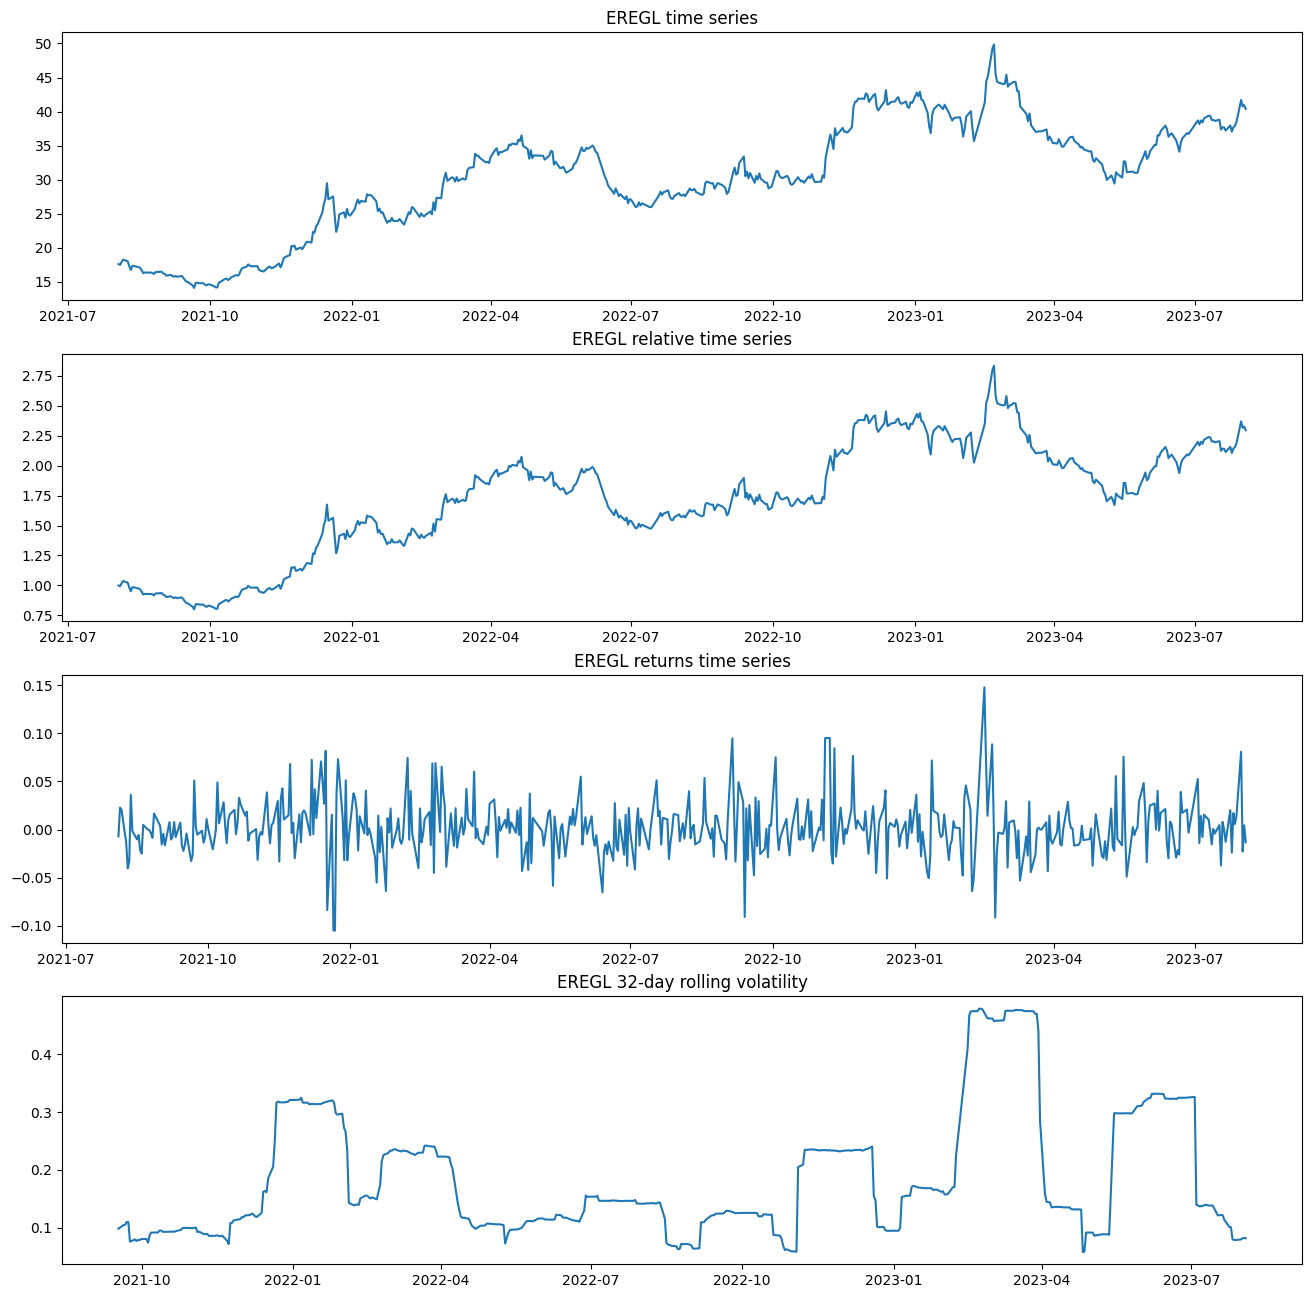

In [40]:
plt.subplot(4, 1, 1)
plt.plot(data_close)
plt.title(f"{Ticker} time series")

plt.subplot(4, 1, 2)
plt.plot(data_rel)
plt.title(f"{Ticker} relative time series")

data_log_returns = data_close.pct_change().apply(lambda x: np.log(1+x))

plt.subplot(4, 1, 3)
plt.plot(data_log_returns)
plt.title(f"{Ticker} returns time series")

plt.subplot(4, 1, 4)
data_vlt = data_close.rolling(R_WINDOW).std()*(252**0.5)

plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.plot(data['std']*252**0.5)

fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.show()

In [ ]:
# Plot cumulative returns

import datetime

plt.figure(figsize=(14,11))

plt.subplot(4, 1, 1)
plt.xlim(LEFT, RIGHT)
plt.plot(data_close)
plt.title(f"{Ticker} time series", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid()

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 2)
plt.xlim(LEFT, RIGHT)
data['cumulative_normal_returns'] = (data.returns+1).cumprod()

plt.plot(data.cumulative_normal_returns)
plt.title(f"{Ticker} normal returns")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 3)
plt.xlim(LEFT, RIGHT)
data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()


plt.plot(data.cumulative_strategy_returns)
plt.title(f"{Ticker} returns time series")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Strategy Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 4)
plt.xlim(LEFT, RIGHT)
plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.xlabel('Date', fontsize=14)
plt.ylabel(f'{Ticker} volatility', fontsize=14)
plt.grid()
plt.xticks(fontsize=12)

plt.plot(data['std']*252**0.5)
fig = plt.gcf()
fig.set_size_inches(16, 22)


plt.show()

In [ ]:
data.loc['2022-11-01':'2023-12-30']

In [ ]:
pyf.create_simple_tear_sheet(data.returns.dropna())

In [ ]:
pyf.create_simple_tear_sheet(data.strategy_returns.dropna())

In [ ]:
np.max(data.cumulative_normal_returns)

In [ ]:
(data.cumulative_normal_returns[-1])

In [ ]:
np.max(data.cumulative_strategy_returns)

In [ ]:
(data.cumulative_strategy_returns[-1])

In [ ]:
data_rel[-1]

In [ ]:
data.cumulative_normal_returns[-1]

In [ ]:
feasible = data.cumulative_normal_returns[-1] / data_rel[-1]

In [ ]:
feasible